<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/Generalized_Transformer_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

# Load the pickled DataFrame
df = pd.read_pickle('/content/drive/MyDrive/databank_learner2.pkl')



In [2]:
!pip install pronto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.4 MB/s eta 0:00:00


In [3]:
import torch
import numpy as np
import pronto
from torch.utils.data import Dataset

# Load PSI-MOD ontology
ontology = pronto.Ontology("/content/drive/MyDrive/PSI-MOD.obo")

def extract_mod_masses_and_locations(int_mod_str, n_term_str):
    masses = []
    locations = []

    def parse_mods(mod_str, force_position=None):
        mods = []
        if not isinstance(mod_str, str) or not any(prefix in mod_str for prefix in ("MOD:", "PSI-MOD:")):
            return mods

        for mod_entry in mod_str.split('|'):
            if '@' in mod_entry:
                mod_part, suffix = mod_entry.split('@')
                try:
                    suffix = int(suffix)
                except ValueError:
                    continue
            else:
                mod_part = mod_entry
                suffix = 0

            if ':' not in mod_part:
                continue

            prefix, number = mod_part.split(':')
            if not number.isdigit():
                continue

            padded_number = number.zfill(5)
            mod_id = f"MOD:{padded_number}"  # Always use MOD:xxxxx for lookup

            if force_position is not None:
                suffix = force_position

            mods.append((mod_id, suffix))
        return mods

    mod_list = parse_mods(n_term_str, force_position=0) + parse_mods(int_mod_str)

    for mod_id, location in mod_list:
        locations.append(location)
        try:
            xrefs = ontology[mod_id].xrefs
            diffavg_desc = next((x.description for x in xrefs if x.id == "DiffAvg:"), None)
            masses.append(float(diffavg_desc))
        except (KeyError, TypeError, ValueError):
            masses.append(0.0)

    return masses, locations


import torch

def create_tertiary_mask_with_mass_shifts(canonical_seq, t_seq, ptm_locs, mass_shifts):
    """
    Returns:
    - mask: torch.LongTensor of shape [len(canonical_seq)], values in {0, 1, 2}
    - mass_vector: torch.FloatTensor of shape [len(canonical_seq)], nonzero only at PTM sites
    """
    if len(ptm_locs) != len(mass_shifts):
        raise ValueError(f"Mismatch: {len(ptm_locs)} PTM locations vs {len(mass_shifts)} mass shifts.")

    seq_len = len(canonical_seq)
    mask = torch.zeros(seq_len, dtype=torch.long)         # ensure long for CE loss
    mass_vector = torch.zeros(seq_len, dtype=torch.float32)

    start_idx = canonical_seq.find(t_seq)
    if start_idx == -1:
        raise ValueError(f"Truncated sequence '{t_seq}' not found in canonical sequence.")

    # Mark entire truncated region as "truncated" = 1
    mask[start_idx:start_idx + len(t_seq)] = 1

    # Mark PTM positions as 2 and assign their mass shifts
    for abs_idx, shift in zip(ptm_locs, mass_shifts):
        if not (0 <= abs_idx < seq_len):
            raise IndexError(f"PTM index {abs_idx} out of bounds for sequence length {seq_len}")
        mask[abs_idx] = 2
        mass_vector[abs_idx] = shift

    return mask, mass_vector


class PTMDataset(Dataset):
    def __init__(self, spectra, labels, deltas):
        assert len(spectra) == len(labels) == len(deltas), "All input lists must be the same length."

        self.spectra = [
            s if isinstance(s, torch.Tensor) else torch.tensor(np.array(s), dtype=torch.float32)
            for s in spectra
        ]
        self.labels = labels
        self.deltas = deltas

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.labels[idx], self.deltas[idx]


In [4]:
spectra = []
labels = []
deltas = []

for i in range(len(df)):
    if df['Uniprot ID'][i] == 'HBB_HUMAN':
        spec = df['cast spectra'][i]
        canonical_seq = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
        t_seq = df['sequence'][i]
        int_mod_str = df['int_mod'][i]
        n_term_str = df['n_term'][i]

        try:
            masses, locations = extract_mod_masses_and_locations(int_mod_str, n_term_str)

            # Filter for only modifications within the canonical sequence
            valid_idxs = [i for i, loc in enumerate(locations) if 0 <= loc < len(canonical_seq)]
            ptm_locs = [locations[i] for i in valid_idxs]
            ptm_masses = [masses[i] for i in valid_idxs]

            mask, mass_vec = create_tertiary_mask_with_mass_shifts(canonical_seq, t_seq, ptm_locs, ptm_masses)

            spectra.append(spec)
            labels.append(mask)
            deltas.append(mass_vec)

        except Exception as e:
            print(f"Skipping index {i} due to error: {e}")

dataset = PTMDataset(spectra, labels, deltas)


Streaming output truncated to the last 5000 lines.
Skipping index 623376 due to error: Truncated sequence 'VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYD' not found in canonical sequence.
Skipping index 623379 due to error: Truncated sequence 'VHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYD' not found in canonical sequence.
Skipping index 623390 due to error: Truncated sequence 'AHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH' not found in canonical sequence.
Skipping index 623399 due to error: Truncated sequence 'AHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH' not found in canonical sequence.
S

In [5]:
from torch.utils.data import DataLoader, random_split

# Example: 80% training, 20% testing
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=147):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Binary PTM Site Classifier ---
class PTMSiteClassifier(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 256)
        self.encoder_pos_enc = PositionalEncoding1D(256, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.head = nn.Linear(256, 1)  # Binary classifier

    def forward(self, spectra):
        x = self.input_proj(spectra).unsqueeze(1).repeat(1, 147, 1)
        x = self.encoder_pos_enc(x)
        x = self.encoder(x)
        return self.head(x).squeeze(-1)  # [B, 147]

# --- Focal Loss for Binary Classification ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probas = torch.sigmoid(logits)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean() if self.reduction == "mean" else focal.sum()

# --- Training ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PTMSiteClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = FocalLoss(alpha=0.9, gamma=2.0)

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, _ in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)  # Binary target

        optimizer.zero_grad()
        logits = model(spectra)  # [B, 147]
        loss = loss_fn(logits, is_modified)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

# --- Evaluation on Test Set ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, _ in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)
        logits = model(spectra)
        preds = (torch.sigmoid(logits) > 0.5).float()

        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

# --- Metrics & Confusion Matrix ---
precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
print(f"\n[TEST] Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Modified", "Modified"])
disp.plot(cmap="Blues")
plt.title("Test Set - PTM Site Confusion Matrix")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=147):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Delta Mass Regressor ---
class DeltaMassRegressor(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, 256)
        self.encoder_pos_enc = PositionalEncoding1D(256, max_len=seq_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, dim_feedforward=512, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.regressor = nn.Linear(256, 1)  # Predict delta mass

    def forward(self, spectra):
        x = self.input_proj(spectra).unsqueeze(1).repeat(1, 147, 1)
        x = self.encoder_pos_enc(x)
        x = self.encoder(x)
        return self.regressor(x).squeeze(-1)  # [B, 147]

# --- Training ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeltaMassRegressor().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, delta_labels in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2)
        delta_labels = delta_labels.to(DEVICE)

        optimizer.zero_grad()
        pred_deltas = model(spectra)  # [B, 147]

        # Only compute loss on modified positions
        loss = loss_fn(pred_deltas[is_modified], delta_labels[is_modified]) if is_modified.any() else torch.tensor(0.0, device=DEVICE)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        all_preds.extend(pred_deltas[is_modified].detach().cpu().numpy())
        all_true.extend(delta_labels[is_modified].cpu().numpy())

    mae = mean_absolute_error(all_true, all_preds) if all_true else 0.0
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f} | MAE on PTMs = {mae:.4f}")

# --- Evaluation on Test Set ---
import seaborn as sns

# --- Evaluation on Test Set ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, delta_labels in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2)
        delta_labels = delta_labels.to(DEVICE)
        pred_deltas = model(spectra)

        all_preds.extend(pred_deltas[is_modified].cpu().numpy())
        all_true.extend(delta_labels[is_modified].cpu().numpy())

mae = mean_absolute_error(all_true, all_preds) if all_true else 0.0
print(f"\n[TEST] Delta Mass MAE on PTM Sites = {mae:.4f}")

# --- Density Plot: True vs Predicted ---
plt.figure(figsize=(6, 5))
sns.kdeplot(x=all_true, y=all_preds, fill=True, cmap="mako", thresh=0.01)
plt.xlabel("True Delta Mass")
plt.ylabel("Predicted Delta Mass")
plt.title("Delta Mass KDE Plot (PTM Sites)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- XLSTM-based PTM Site Classifier ---
class XLSTM_PTMSiteClassifier(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147, hidden_dim=256, num_layers=2, dropout=0.3):
        super().__init__()
        self.seq_len = seq_len

        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        self.norm = nn.LayerNorm(hidden_dim * 2)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, 1)  # Binary classifier
        )

    def forward(self, spectra):
        x = self.input_proj(spectra)  # [B, 1600] → [B, hidden]
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # [B, seq_len, hidden]
        x, _ = self.lstm(x)  # [B, seq_len, hidden*2]
        x = self.norm(x)
        return self.classifier(x).squeeze(-1)  # [B, seq_len]

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probas = torch.sigmoid(logits)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean() if self.reduction == "mean" else focal.sum()

# --- Training Loop ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = XLSTM_PTMSiteClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = FocalLoss(alpha=0.9, gamma=2.0)

for epoch in range(10):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, _ in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)

        optimizer.zero_grad()
        logits = model(spectra)  # [B, 147]
        loss = loss_fn(logits, is_modified)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

# --- Evaluation ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, _ in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)
        logits = model(spectra)
        preds = (torch.sigmoid(logits) > 0.5).float()

        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
print(f"\n[TEST] Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Modified", "Modified"])
disp.plot(cmap="Blues")
plt.title("Test Set - PTM Site Confusion Matrix")
plt.tight_layout()
plt.show()


Epoch 1: Loss = 0.0091 | Precision = 0.4155 | Recall = 0.1278 | F1 = 0.1955
Epoch 2: Loss = 0.0070 | Precision = 0.5456 | Recall = 0.1980 | F1 = 0.2905
Epoch 3: Loss = 0.0067 | Precision = 0.5793 | Recall = 0.2317 | F1 = 0.3310
Epoch 4: Loss = 0.0066 | Precision = 0.5941 | Recall = 0.2590 | F1 = 0.3607
Epoch 5: Loss = 0.0064 | Precision = 0.6029 | Recall = 0.2783 | F1 = 0.3808
Epoch 6: Loss = 0.0063 | Precision = 0.6099 | Recall = 0.2976 | F1 = 0.4000
Epoch 7: Loss = 0.0063 | Precision = 0.6136 | Recall = 0.3070 | F1 = 0.4093
Epoch 8: Loss = 0.0062 | Precision = 0.6172 | Recall = 0.3209 | F1 = 0.4223
Epoch 9: Loss = 0.0061 | Precision = 0.6193 | Recall = 0.3315 | F1 = 0.4319
Epoch 10: Loss = 0.0061 | Precision = 0.6202 | Recall = 0.3404 | F1 = 0.4395
Epoch 11: Loss = 0.0060 | Precision = 0.6240 | Recall = 0.3464 | F1 = 0.4455
Epoch 12: Loss = 0.0060 | Precision = 0.6267 | Recall = 0.3491 | F1 = 0.4484
Epoch 13: Loss = 0.0060 | Precision = 0.6269 | Recall = 0.3572 | F1 = 0.4551
Epoch 14

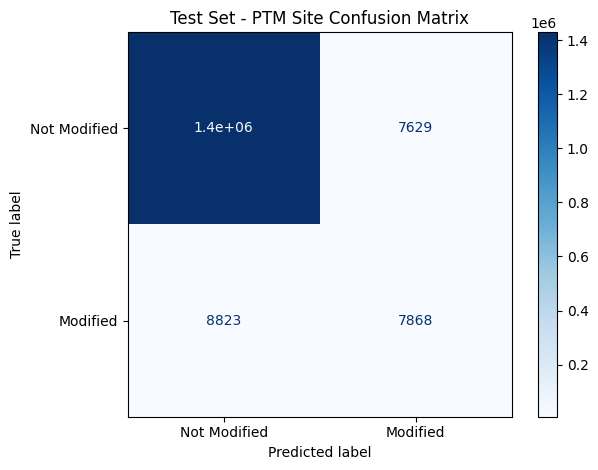

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=147):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Hybrid PTM Classifier ---
class Hybrid_PTMSiteClassifier(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147, hidden_dim=256, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.seq_len = seq_len

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            dropout=dropout,  # dropout applied between LSTM layers
            batch_first=True,
            bidirectional=True
        )

        self.pos_encoder = PositionalEncoding1D(d_model=hidden_dim * 2, max_len=seq_len)

        transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim * 2,
            nhead=8,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=2)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, spectra):
        x = self.input_proj(spectra)  # [B, 1600] -> [B, hidden]
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # [B, 147, hidden]
        x, _ = self.bilstm(x)  # [B, 147, hidden*2]
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.classifier(x).squeeze(-1)  # [B, 147]

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probas = torch.sigmoid(logits)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean() if self.reduction == "mean" else focal.sum()

# --- Training ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Hybrid_PTMSiteClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = FocalLoss(alpha=0.9, gamma=2.0)

# --- Replace with your DataLoader ---
# train_loader = ...
# test_loader = ...

for epoch in range(100):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, _ in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)

        optimizer.zero_grad()
        logits = model(spectra)  # [B, 147]
        loss = loss_fn(logits, is_modified)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

# --- Evaluation ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, _ in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)
        logits = model(spectra)
        preds = (torch.sigmoid(logits) > 0.5).float()

        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
print(f"\n[TEST] Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Modified", "Modified"])
disp.plot(cmap="Blues")
plt.title("Test Set - PTM Site Confusion Matrix")
plt.tight_layout()
plt.show()


Epoch 1: Loss = 0.0087 | Precision = 0.4401 | Recall = 0.1102 | F1 = 0.1763
Epoch 2: Loss = 0.0069 | Precision = 0.5707 | Recall = 0.2006 | F1 = 0.2969
Epoch 3: Loss = 0.0066 | Precision = 0.5927 | Recall = 0.2316 | F1 = 0.3330
Epoch 4: Loss = 0.0065 | Precision = 0.6113 | Recall = 0.2549 | F1 = 0.3597
Epoch 5: Loss = 0.0064 | Precision = 0.6162 | Recall = 0.2696 | F1 = 0.3751
Epoch 6: Loss = 0.0063 | Precision = 0.6161 | Recall = 0.2884 | F1 = 0.3929
Epoch 7: Loss = 0.0063 | Precision = 0.6190 | Recall = 0.2990 | F1 = 0.4033
Epoch 8: Loss = 0.0062 | Precision = 0.6246 | Recall = 0.3147 | F1 = 0.4185
Epoch 9: Loss = 0.0061 | Precision = 0.6288 | Recall = 0.3326 | F1 = 0.4351
Epoch 10: Loss = 0.0061 | Precision = 0.6284 | Recall = 0.3392 | F1 = 0.4406
Epoch 11: Loss = 0.0060 | Precision = 0.6304 | Recall = 0.3459 | F1 = 0.4467
Epoch 12: Loss = 0.0060 | Precision = 0.6333 | Recall = 0.3496 | F1 = 0.4505
Epoch 13: Loss = 0.0059 | Precision = 0.6376 | Recall = 0.3635 | F1 = 0.4630
Epoch 14

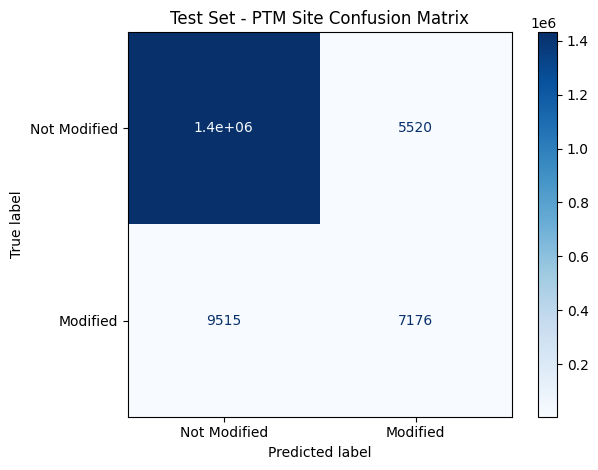

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# --- Positional Encoding ---
class PositionalEncoding1D(nn.Module):
    def __init__(self, d_model, max_len=147):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# --- Gated Attention Classifier ---
class GatedAttentionClassifier(nn.Module):
    def __init__(self, input_dim, dropout=0.3):
        super().__init__()
        self.gate_fc = nn.Linear(input_dim, input_dim)
        self.out_fc = nn.Linear(input_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        gate = torch.sigmoid(self.gate_fc(x))  # [B, seq_len, H]
        gated_output = gate * x                # [B, seq_len, H]
        gated_output = self.dropout(gated_output)
        return self.out_fc(gated_output).squeeze(-1)  # [B, seq_len]

# --- Hybrid PTM Classifier with Gated Attention ---
class Hybrid_PTMSiteClassifier(nn.Module):
    def __init__(self, input_dim=1600, seq_len=147, hidden_dim=256, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.seq_len = seq_len

        self.input_proj = nn.Linear(input_dim, hidden_dim)

        self.bilstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            dropout=dropout,
            batch_first=True,
            bidirectional=True
        )

        self.pos_encoder = PositionalEncoding1D(d_model=hidden_dim * 2, max_len=seq_len)

        transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim * 2,
            nhead=8,
            dim_feedforward=512,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=2)

        # --- Gated attention head ---
        self.classifier = GatedAttentionClassifier(hidden_dim * 2, dropout=dropout)

    def forward(self, spectra):
        x = self.input_proj(spectra)  # [B, 1600] → [B, hidden]
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # [B, 147, hidden]
        x, _ = self.bilstm(x)  # [B, 147, hidden*2]
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.classifier(x)  # [B, 147]

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        bce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probas = torch.sigmoid(logits)
        pt = probas * targets + (1 - probas) * (1 - targets)
        focal = self.alpha * (1 - pt) ** self.gamma * bce
        return focal.mean() if self.reduction == "mean" else focal.sum()

# --- Training ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Hybrid_PTMSiteClassifier().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = FocalLoss(alpha=0.9, gamma=2.0)

# --- Replace with your DataLoader ---
# train_loader = ...
# test_loader = ...

for epoch in range(20):
    model.train()
    total_loss = 0
    all_preds, all_true = [], []

    for spectra, status_labels, _ in train_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)

        optimizer.zero_grad()
        logits = model(spectra)  # [B, 147]
        loss = loss_fn(logits, is_modified)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(logits) > 0.5).float()
        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

    precision = precision_score(all_true, all_preds, zero_division=0)
    recall = recall_score(all_true, all_preds, zero_division=0)
    f1 = f1_score(all_true, all_preds, zero_division=0)
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_loader):.4f} | Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

# --- Evaluation ---
model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for spectra, status_labels, _ in test_loader:
        spectra = spectra.to(DEVICE)
        is_modified = (status_labels == 2).float().to(DEVICE)
        logits = model(spectra)
        preds = (torch.sigmoid(logits) > 0.5).float()

        all_preds.extend(preds.cpu().numpy().ravel())
        all_true.extend(is_modified.cpu().numpy().ravel())

precision = precision_score(all_true, all_preds, zero_division=0)
recall = recall_score(all_true, all_preds, zero_division=0)
f1 = f1_score(all_true, all_preds, zero_division=0)
print(f"\n[TEST] Precision = {precision:.4f} | Recall = {recall:.4f} | F1 = {f1:.4f}")

cm = confusion_matrix(all_true, all_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Modified", "Modified"])
disp.plot(cmap="Blues")
plt.title("Test Set - PTM Site Confusion Matrix")
plt.tight_layout()
plt.show()
